# Part 3


In [1]:
try:
    import io
    import re
    import os
    import sys
    import numpy as np
    import elasticsearch
    from elasticsearch import Elasticsearch 
    import pandas as pd
    from elasticsearch import helpers
    import warnings
    import string

    import nltk #statistical natural language processing
    warnings.filterwarnings('ignore')

    print("All Modules Loaded ! ")
except Exception as e:
    print("Some Modules are Missing {}".format(e))
    

All Modules Loaded ! 


### Dataset Preparation 
#### The steps below are also  described in previews parts

##### We Found that the User " 11676" has the most rated books in the user rating dataset

In [2]:
user = int(input("Input User Id :")) 

Input User Id :11676


In [3]:
df = pd.read_csv("BX-Books.csv") # Book Dataset
rdf = pd.read_csv("BX-Book-Ratings.csv") # User Ratign Dataset

In [4]:
df.shape

(134692, 7)

In [5]:
rdf.shape

(1031175, 3)

 Add rating Column based on the avg of the books User ratings. "new" is the dataset with isbn and mean rating of each book . It has different shape than df though...
 

In [6]:
new = rdf.groupby('isbn',as_index= False).rating.mean()
new.head() 

,isbn,rating
0,0000913154,8.0
1,0001010565,0.0
2,0001046438,9.0
3,0001046713,0.0
4,000104687X,6.0


In [7]:
df.shape

(134692, 7)

In [8]:
new.shape

(270170, 2)

"user_r" is the dataset with each users rated books.

In [9]:
user_r = rdf[rdf['uid']== user]
user_r = user_r.drop(['uid'], axis=1) # Drop 'uid' because it will be the users id which will be the same. 
user_r = user_r.rename({'rating': 'user_rating'}, axis=1)
user_r.shape

(11144, 2)

In [10]:
user_r.head()

,isbn,user_rating
3,0002005018,8
31,0399135782,9
69,0671870432,8
74,0771074670,0
112,0440234743,9


In [11]:
result = pd.merge(df, new, on="isbn", how="inner", validate="one_to_one")
result.head()

,isbn,book_title,book_author,year_of_publication,publisher,summary,category,rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,Provides an introduction to classical myths pl...,['social science'],0.000000
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",['actresses'],4.928571
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,"Here, for the first time in paperback, is an o...",['1940-1949'],5.000000
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,"Describes the great flu epidemic of 1918, an o...",['medical'],4.272727
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,A look at the incredibly well-preserved ancien...,['design'],0.000000


In [12]:
result.shape

(134692, 8)

Merge user_r with the Initial Books Dataset via inner join in order to have a Dataset that has both the Avg rating for each book (if it exists) and the chosen users Ratings . 

In [13]:
final = pd.merge(result,user_r, on="isbn", how="left", validate="one_to_one")
final.head(3)

,isbn,book_title,book_author,year_of_publication,publisher,summary,category,rating,user_rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,Provides an introduction to classical myths pl...,['social science'],0.000000,NaN
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",['actresses'],4.928571,8.0
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,"Here, for the first time in paperback, is an o...",['1940-1949'],5.000000,NaN


In [14]:
final['user_rating'] = final['user_rating'].fillna(0)

In [15]:
final.head(3)

,isbn,book_title,book_author,year_of_publication,publisher,summary,category,rating,user_rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,Provides an introduction to classical myths pl...,['social science'],0.000000,0.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",['actresses'],4.928571,8.0
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,"Here, for the first time in paperback, is an o...",['1940-1949'],5.000000,0.0


In [16]:
final.shape

(134692, 9)

## Text Preprocessing


### Remove Stopwords

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Charalampos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
final['clear_summary'] = final['summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
final.head()

,isbn,book_title,book_author,year_of_publication,publisher,summary,category,rating,user_rating,clear_summary
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,Provides an introduction to classical myths pl...,['social science'],0.000000,0.0,Provides introduction classical myths placing ...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",['actresses'],4.928571,8.0,"In small town Canada, Clara Callan reluctantly..."
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,"Here, for the first time in paperback, is an o...",['1940-1949'],5.000000,0.0,"Here, first time paperback, outstanding milita..."
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,"Describes the great flu epidemic of 1918, an o...",['medical'],4.272727,0.0,"Describes great flu epidemic 1918, outbreak ki..."
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,A look at the incredibly well-preserved ancien...,['design'],0.000000,0.0,A look incredibly well-preserved ancient mummi...


In [19]:
print(final['clear_summary'].iloc[0])
print(final['clear_summary'].iloc[50])

Provides introduction classical myths placing addressed topics within historical context, discussion archaeological evidence support mythical events, themes portrayed literature, art, ...
Generally regarded pre-eminent work Conrad&#39;s shorter fiction, &#39;Heart Darkness&#39; chilling tale horror which, author intended, capable many interpretations.


### Also Remove Numeric Characters

In [20]:
final['clear_summary'] = final['clear_summary'].str.replace('\d+', '')

### Remove Punctuation

In [21]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [22]:
final['clear_summary'] = final['clear_summary'].apply(lambda x: "".join([char for char in x if char not in string.punctuation]))

In [23]:
print(final['clear_summary'].iloc[0])
print(final['clear_summary'].iloc[50])

Provides introduction classical myths placing addressed topics within historical context discussion archaeological evidence support mythical events themes portrayed literature art 
Generally regarded preeminent work Conrads shorter fiction Heart Darkness chilling tale horror which author intended capable many interpretations


### Lowercase 

In [24]:
final['clear_summary'] = final['clear_summary'].apply(lambda x: ' '.join([w.lower() for w in str(x).split()]))
print(final['clear_summary'].iloc[0])
print(final['clear_summary'].iloc[150])

provides introduction classical myths placing addressed topics within historical context discussion archaeological evidence support mythical events themes portrayed literature art
when little boys pet dies persuades parents bury old indian cemetary reputed legend house restless spirits nightmare death destruction begins deceased animals come back life reissue


### Stemming

Stem words to extract its lexical meaning, and also reduce the vocabulary created later on. 

In [25]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [26]:
final['clear_summary_stem'] = final['clear_summary'].apply(lambda x: ' '.join([stemmer.stem(w) for w in str(x).split()]))

In [27]:
final.head(2)

,isbn,book_title,book_author,year_of_publication,publisher,summary,category,rating,user_rating,clear_summary,clear_summary_stem
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,Provides an introduction to classical myths pl...,['social science'],0.000000,0.0,provides introduction classical myths placing ...,provid introduct classic myth place address to...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",['actresses'],4.928571,8.0,in small town canada clara callan reluctantly ...,in small town canada clara callan reluct take ...


In [28]:
print(final['clear_summary'].iloc[150])

when little boys pet dies persuades parents bury old indian cemetary reputed legend house restless spirits nightmare death destruction begins deceased animals come back life reissue


## Split Dataset Into Useable Data and Data with user ratings that are going be predicted
##### train data ( user_rating != 0 )These are the Data which have not null User Ratings (!=0) 

#### null_rat data (user_rating ==0) These are the Data which have null User Ratings (!=0). 
#### We are going to predict the user ratings of these later.

In [29]:
train = final[final['user_rating']!=0] 
train.shape

(3820, 11)

In [30]:
null_rat =  final[final['user_rating'] ==0 ] # Zero User Rating
null_rat.shape

(130872, 11)

In [31]:
train.head(2)

,isbn,book_title,book_author,year_of_publication,publisher,summary,category,rating,user_rating,clear_summary,clear_summary_stem
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",['actresses'],4.928571,8.0,in small town canada clara callan reluctantly ...,in small town canada clara callan reluct take ...
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,A Chinese immigrant who is convinced she is dy...,['fiction'],4.212121,9.0,a chinese immigrant convinced dying threatens ...,a chines immigr convinc die threaten celebr ch...


Set the two Main Values that we need. The processed Summaries and the ratings

In [32]:
text = train['clear_summary_stem'] #These are the preprocessed summaries of each book.
ratings = train['user_rating']

pred_text = null_rat['clear_summary_stem']
pred_rating = null_rat['user_rating']

## Train

### Load pre-trained word embeddings


##### In order to get the represenation of each document as a vector we will use gensims Doc2vec.

In [33]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Charalampos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [34]:
alldocs=final['clear_summary_stem']

Tag the documents in order to keep the index of each doc.

In [35]:
tag_data = [TaggedDocument(words=word_tokenize(_d.lower()), 
            tags=[str(i)]) for i, _d in enumerate(alldocs)]

In [36]:
"""def build_model(max_epochs, vec_size, alpha, tagged_data):
    
    model = Doc2Vec(vector_size=vec_size,
               alpha=alpha,
               min_alpha=0.00025,
               negative=5,
               min_count=2,
               dm=0)

    model.build_vocab(tag_data)
    
    # With the model built we simply train on the data.
    
    for epoch in range(max_epochs):
        print(f"Iteration {epoch}")
        model.train(tag_data,
                   total_examples=model.corpus_count,
                   epochs=model.epochs)

        # Here I decrease the learning rate. 

        model.alpha -= 0.0002

        model.min_alpha = model.alpha
    
    # Now simply save the model to avoid training again. 
    
    model.save("D2V_Model.model")
    print("Model Saved")
    return model

model = build_model(max_epochs=10, vec_size=40, alpha=0.025, tagged_data=tag_data)"""

'def build_model(max_epochs, vec_size, alpha, tagged_data):\n    \n    model = Doc2Vec(vector_size=vec_size,\n               alpha=alpha,\n               min_alpha=0.00025,\n               negative=5,\n               min_count=2,\n               dm=0)\n\n    model.build_vocab(tag_data)\n    \n    # With the model built we simply train on the data.\n    \n    for epoch in range(max_epochs):\n        print(f"Iteration {epoch}")\n        model.train(tag_data,\n                   total_examples=model.corpus_count,\n                   epochs=model.epochs)\n\n        # Here I decrease the learning rate. \n\n        model.alpha -= 0.0002\n\n        model.min_alpha = model.alpha\n    \n    # Now simply save the model to avoid training again. \n    \n    model.save("D2V_Model.model")\n    print("Model Saved")\n    return model\n\nmodel = build_model(max_epochs=10, vec_size=40, alpha=0.025, tagged_data=tag_data)'

##### PV-DM Took ~ 4.20 mins (dm=1) ( tested for 4 epochs with vector size = 40) 
##### PV-DBOW Took ~ 2.30 mins (dm=0)
##### We use PV-DBOW because we do not need to keep the weights for each word, we only need the vectors of each document.
##### You don't need to train the model again just load the file ...


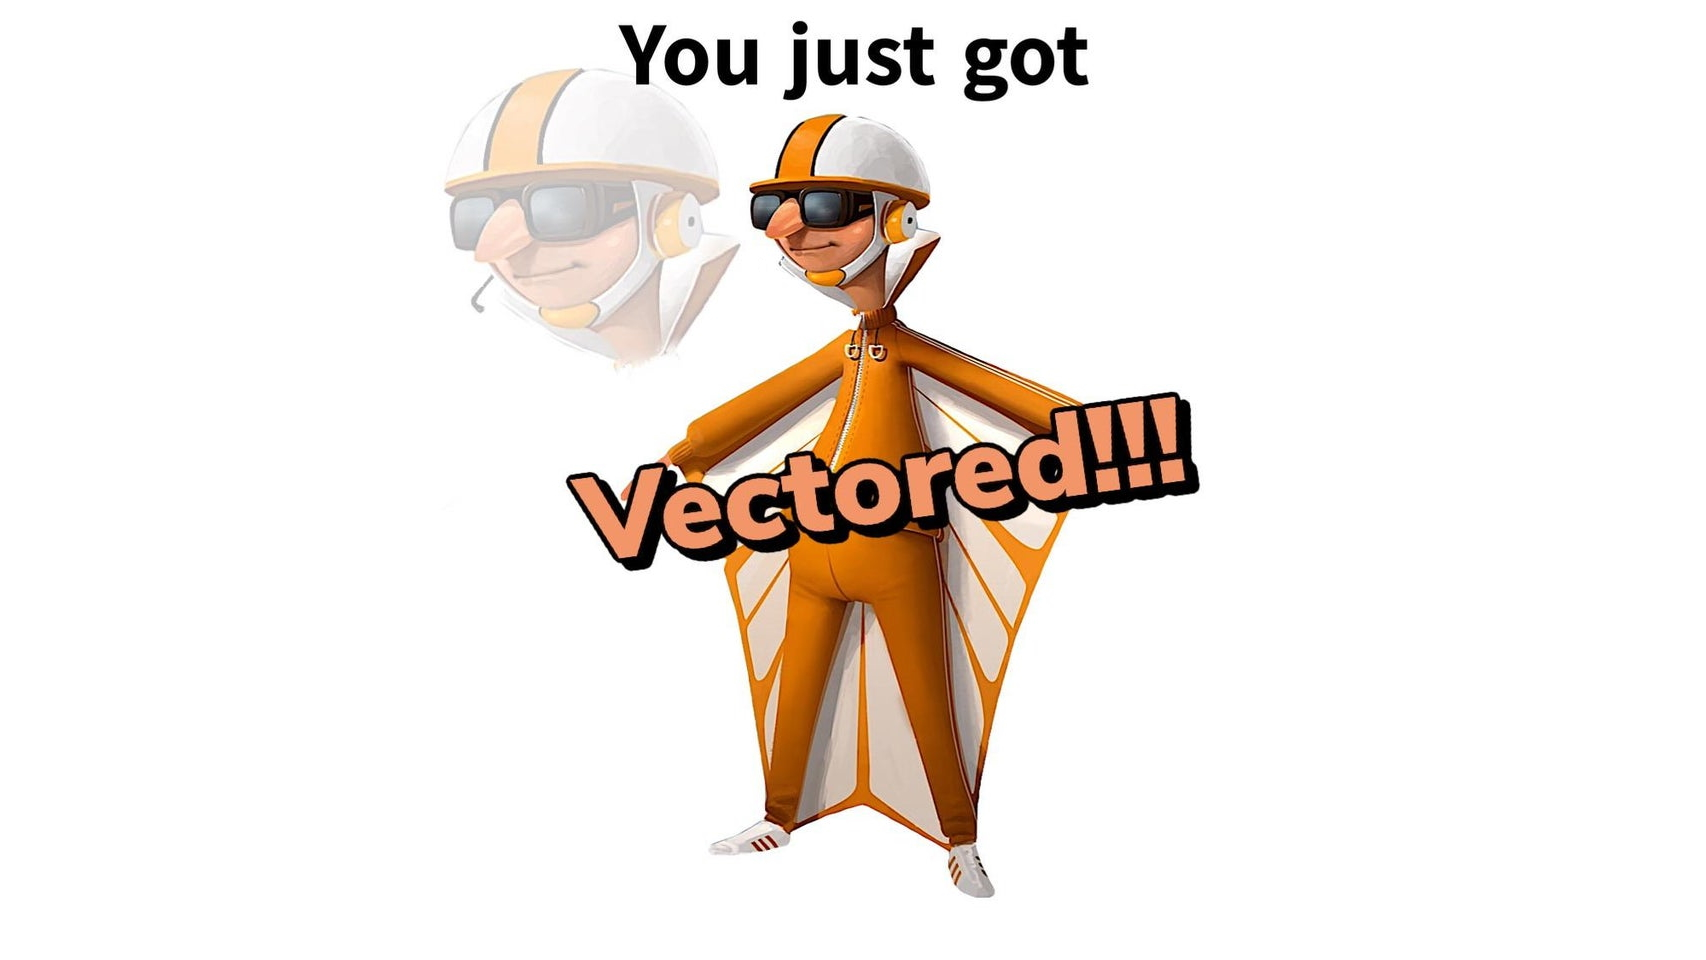

In [37]:
from IPython.display import Image
Image("vector.jpg")

In [38]:
model=Doc2Vec.load("D2V_Model.model")

Check if the Model is useful.

In [39]:
model.wv.similar_by_word("kill")

[('mysterio', 0.6211808323860168),
 ('zlata', 0.5934056639671326),
 ('rapistmurder', 0.5566440224647522),
 ('stoltzfus', 0.5440924167633057),
 ('worldth', 0.5425503253936768),
 ('quotalthough', 0.5339058637619019),
 ('bestsel', 0.5312341451644897),
 ('statecraft', 0.5284039974212646),
 ('stoddard', 0.5274983644485474),
 ('darren', 0.5202333927154541)]

We use PV-DBOW so we dont expect to see  relevant words

In [40]:
model.docvecs.most_similar(4)

[('40766', 0.7442135810852051),
 ('110869', 0.7325815558433533),
 ('134190', 0.7037688493728638),
 ('112587', 0.6963385343551636),
 ('125909', 0.6892833113670349),
 ('23305', 0.6869984269142151),
 ('92305', 0.6869886517524719),
 ('47774', 0.6868658661842346),
 ('36474', 0.6819773316383362),
 ('21377', 0.6800673604011536)]

In [41]:
print(final['book_title'].iloc[4])
print(final['summary'].iloc[4])


The Mummies of Urumchi
A look at the incredibly well-preserved ancient mummies found in
Western China describes their clothing and appearance, attempts to
reconstruct their culture, and speculates about how Caucasians could
have found their way to the feet of the ...


In [42]:
print(final['book_title'].iloc[40766])
print(final['summary'].iloc[40766])


History of Western Science, A
Presented in an informal, narrative style, this text looks at science,
from the ancient world , to medieval science, the scientific
revolution, through to 20th century physics.


###### If we check the books that where returned as similar we will find a lot of that may appear to be about the same topic. 

### Note 
 If you train again you may get different results.

In [43]:
final[final['isbn'] == '059035342X']

,isbn,book_title,book_author,year_of_publication,publisher,summary,category,rating,user_rating,clear_summary,clear_summary_stem
1731,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books,Rescued from the outrageous neglect of his aun...,['juvenile fiction'],4.900175,10.0,rescued outrageous neglect aunt uncle young bo...,rescu outrag neglect aunt uncl young boy great...


This is a way of finding the most related summary to any given sentence. For example this could be any input query.

In [44]:
test_data = word_tokenize("a young boy in a world full of wizards elfs and monsters  ".lower())
v1 = model.infer_vector(test_data)
print("V1_infer", v1)

# to find most similar doc using tags
similar_doc = model.docvecs.most_similar([v1])
print(similar_doc)


V1_infer [-0.21440996 -0.3024022   0.03730056 -0.35759088  0.14431724 -0.39303243
  0.06229186 -0.31162986 -0.14113654 -0.1477221   0.10381263  0.20550574
  0.05129218 -0.09876433 -0.03648067 -0.33026907 -0.06509876 -0.25817505
 -0.26771358 -0.29220417 -0.44619444  0.6838456   0.29189092 -0.14370586
 -0.3093682   0.20535436  0.51059777  0.01563767 -0.0623865  -0.36251253
  0.34203264  0.23973164  0.05451896  0.05871656 -0.3420558   0.32873812
 -0.61807454 -0.18861395  0.06956042 -0.05901311]
[('25857', 0.7160467505455017), ('93078', 0.7122541666030884), ('90126', 0.7119066715240479), ('107411', 0.7098625302314758), ('27848', 0.706214189529419), ('40295', 0.7043367624282837), ('44757', 0.703334391117096), ('35446', 0.7001020312309265), ('15123', 0.6939405202865601), ('134481', 0.6897911429405212)]


In [45]:
print(final['book_title'].iloc[15123])

Letters for Emily


In [46]:
print(final['summary'].iloc[15123])

You are so young.


In [47]:
d2v_model = model 

Convert summaries with non null reviews to list .

In [48]:
train_docs_list = text.to_list()

model.infer_vector(train_docs_list[0].split())

array([ 0.27582797, -0.03592452, -0.12434436, -0.2918064 ,  0.39590514,
       -0.20269367, -0.3423791 ,  0.13735496, -0.16031212, -0.256596  ,
       -0.28743345, -0.19839434,  0.09841236,  0.717132  ,  0.01056437,
       -0.29734063, -0.3534559 , -0.14634174,  0.5148212 , -0.26850116,
       -0.07572267,  0.30224493, -0.4253234 , -0.35837805, -0.6427105 ,
        0.1622864 ,  0.03571999, -0.28947967, -0.14290215,  0.22106966,
        0.04942074,  0.48206174,  0.18400131,  0.22564851, -0.5806885 ,
        0.7018714 , -0.6243832 , -0.3048036 , -0.4671427 ,  0.50571775],
      dtype=float32)

Split each sentence in the list, and append to result list

In [49]:
def split_list(sentence):
    result = []
    for s in sentence:
        result.append(s.split())
    return result

final_list= split_list(train_docs_list)

RR is the final list with the vectored Summaries

In [50]:
RR=[]
for i in final_list : 
    RR.append(model.infer_vector(i))

In [51]:
train['vector']=RR

In [52]:
train.head()

,isbn,book_title,book_author,year_of_publication,publisher,summary,category,rating,user_rating,clear_summary,clear_summary_stem,vector
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",['actresses'],4.928571,8.0,in small town canada clara callan reluctantly ...,in small town canada clara callan reluct take ...,"[0.28106096, 0.090453595, -0.25103736, -0.2579..."
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,A Chinese immigrant who is convinced she is dy...,['fiction'],4.212121,9.0,a chinese immigrant convinced dying threatens ...,a chines immigr convinc die threaten celebr ch...,"[0.31299034, 0.3149997, -0.28059196, -0.448891..."
13,0440234743,The Testament,John Grisham,1999,Dell,"A suicidal billionaire, a burnt-out Washington...",['fiction'],3.085308,9.0,a suicidal billionaire burntout washington lit...,a suicid billionair burntout washington litig ...,"[-0.3051638, 0.16125838, 0.4299025, -0.4603542..."
14,0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison,1994,Plume,Staring unflinchingly into the abyss of slaver...,['fiction'],3.411111,8.0,staring unflinchingly abyss slavery novel tran...,stare unflinch abyss slaveri novel transform h...,"[-0.4654744, -0.2592744, 0.5294679, -0.4888943..."
15,0609804618,Our Dumb Century: The Onion Presents 100 Years...,The Onion,1999,Three Rivers Press,The staff of The Onion presents a satirical co...,['humor'],5.684211,7.0,the staff the onion presents satirical collect...,the staff the onion present satir collect mock...,"[-0.63168454, 0.18599613, -0.17609163, -0.0910..."


In [53]:
len(RR)

3820

In [54]:
X_train = RR
len(X_train)


3820

In [55]:
len(ratings)

3820

Split the data with non null ratings. 

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
train_sentences, test_sentences, train_ratings, test_ratings = train_test_split(X_train, ratings, test_size=0.3, random_state=42 )

In [58]:
from sklearn.linear_model import LinearRegression
lreg = LinearRegression()
lreg.fit(train_sentences, train_ratings)

LinearRegression()

In [59]:
y_pred = lreg.predict(test_sentences)
y_pred[3]

7.799322

In [60]:
np.sqrt(np.mean((test_ratings- y_pred)**2))

2.0120058583925524

In [61]:
y_pred

array([7.7636604, 7.2005568, 7.4564342, ..., 7.0413923, 7.62733  ,
       8.095916 ], dtype=float32)

In [62]:
test_ratings

14223    10.0
11893     8.0
13592     8.0
15719     8.0
15019    10.0
         ... 
1259      7.0
12851    10.0
9195     10.0
10111     5.0
15910     7.0
Name: user_rating, Length: 1146, dtype: float64

### Predict Rating Values. (Apply Regression) 

Convert dataset to list

In [63]:
pred_docs_list = pred_text.to_list()
final_pred_list= split_list(pred_docs_list)

In [64]:
FF=[]
for i in final_pred_list : 
    FF.append(model.infer_vector(i))

In [65]:
X_pred=FF

In [66]:
Y_pred = lreg.predict(X_pred)

In [67]:
Y_pred

array([7.756647 , 7.7001443, 8.234027 , ..., 7.931826 , 7.494736 ,
       7.8958144], dtype=float32)

In [68]:
len(Y_pred)

130872

In [69]:
null_rat['user_rating'] = Y_pred

In [70]:
null_rat['vector']=FF

In [71]:
null_rat.head()

,isbn,book_title,book_author,year_of_publication,publisher,summary,category,rating,user_rating,clear_summary,clear_summary_stem,vector
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,Provides an introduction to classical myths pl...,['social science'],0.000000,7.756647,provides introduction classical myths placing ...,provid introduct classic myth place address to...,"[-0.4178257, -0.49786973, 0.20962027, -0.26985..."
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,"Here, for the first time in paperback, is an o...",['1940-1949'],5.000000,7.700144,here first time paperback outstanding military...,here first time paperback outstand militari hi...,"[-0.41022778, 0.062368963, -0.032600842, -0.33..."
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,"Describes the great flu epidemic of 1918, an o...",['medical'],4.272727,8.234027,describes great flu epidemic outbreak killed f...,describ great flu epidem outbreak kill forti m...,"[0.23202969, -0.39174357, 0.22612667, -0.65371..."
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,A look at the incredibly well-preserved ancien...,['design'],0.000000,7.183255,a look incredibly wellpreserved ancient mummie...,a look incred wellpreserv ancient mummi found ...,"[-0.74110186, -0.15781179, 0.297261, -0.182971..."
6,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,"Essays by respected military historians, inclu...",['history'],1.600000,7.559475,essays respected military historians including...,essay respect militari historian includ stephe...,"[-0.34348112, 0.3280173, 0.22075865, -0.621632..."


Join null user rating Dataframe with non null user rating Dataframe

In [72]:
Output=pd.concat([train,null_rat])

In [73]:
Output.head()

,isbn,book_title,book_author,year_of_publication,publisher,summary,category,rating,user_rating,clear_summary,clear_summary_stem,vector
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",['actresses'],4.928571,8.0,in small town canada clara callan reluctantly ...,in small town canada clara callan reluct take ...,"[0.28106096, 0.090453595, -0.25103736, -0.2579..."
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,A Chinese immigrant who is convinced she is dy...,['fiction'],4.212121,9.0,a chinese immigrant convinced dying threatens ...,a chines immigr convinc die threaten celebr ch...,"[0.31299034, 0.3149997, -0.28059196, -0.448891..."
13,0440234743,The Testament,John Grisham,1999,Dell,"A suicidal billionaire, a burnt-out Washington...",['fiction'],3.085308,9.0,a suicidal billionaire burntout washington lit...,a suicid billionair burntout washington litig ...,"[-0.3051638, 0.16125838, 0.4299025, -0.4603542..."
14,0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison,1994,Plume,Staring unflinchingly into the abyss of slaver...,['fiction'],3.411111,8.0,staring unflinchingly abyss slavery novel tran...,stare unflinch abyss slaveri novel transform h...,"[-0.4654744, -0.2592744, 0.5294679, -0.4888943..."
15,0609804618,Our Dumb Century: The Onion Presents 100 Years...,The Onion,1999,Three Rivers Press,The staff of The Onion presents a satirical co...,['humor'],5.684211,7.0,the staff the onion presents satirical collect...,the staff the onion present satir collect mock...,"[-0.63168454, 0.18599613, -0.17609163, -0.0910..."


In [74]:
Output=Output.sort_index()

## Elasticsearch

In [75]:
ENDPOINT = "http://localhost:9200/"
es = Elasticsearch(timeout=600,hosts=ENDPOINT)

In [76]:
es.ping

<bound method Elasticsearch.ping of <Elasticsearch([{'host': 'localhost', 'port': 9200}])>>

In [77]:
elastic_data = Output.to_dict('records')

In [78]:
def generator(elastic_data):
    for c, line in enumerate(elastic_data):
        yield{
            '_index':'rbooks_elk',
            '_type':'_doc',
            '_id':line.get("isbn",None),
            '_source':{
                "title":line.get("book_title",""),
                "author":line.get("book_author",""),
                "summary":line.get("summary",""),
                "category":line.get("category",""),
                "year":line.get("year_of_publication",None),
                "publisher":line.get("publisher",""),
                "rating":line.get("rating",None),
                "user_rating":line.get("user_rating",None)
                
            }        
    }
    raise StopIteration

In [79]:
custom = generator(elastic_data)

In [80]:
next(custom)

{'_index': 'rbooks_elk',
 '_type': '_doc',
 '_id': '0195153448',
 '_source': {'title': 'Classical Mythology',
  'author': 'Mark P. O. Morford',
  'summary': 'Provides an introduction to classical myths placing the addressed\ntopics within their historical context, discussion of archaeological\nevidence as support for mythical events, and how these themes have\nbeen portrayed in literature, art, ...',
  'category': "['social science']",
  'year': 2002,
  'publisher': 'Oxford University Press',
  'rating': 0.0,
  'user_rating': 7.756647109985352}}

In [81]:
len(elastic_data)

134692

In [82]:
try:
    res = helpers.bulk( es , generator(elastic_data))
    print("Working")
except Exception as e : 
    pass

In [83]:
inp = input("Search Book: ")
myquery = {
   "_source":["title","year","author","rating","user_rating" ],
  "size":20,
  "track_scores":True,
  "query": {
    "match": {
      "title": inp
    }
  },
   "sort": [
       {"_script":
        {
      "type": "number",
      
      "script":{
        "lang": "painless", 
        "source":  "_score*3+doc['rating'].value+doc['user_rating'].value*2"
      },
      "order": "desc"
      }
    }
  ]
}


Search Book: Harry Potter


In [84]:
res = es.search (
    index='rbooks_elk',
    size= 10,
    body= myquery  
 )

In [85]:
res

{'took': 4007,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 142, 'relation': 'eq'},
  'max_score': 18.133854,
  'hits': [{'_index': 'rbooks_elk',
    '_type': '_doc',
    '_id': '059035342X',
    '_score': 18.133854,
    '_source': {'year': 1999,
     'author': 'J. K. Rowling',
     'rating': 4.900175131348512,
     'title': "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))",
     'user_rating': 10.0},
    'sort': [79.30173683166504]},
   {'_index': 'rbooks_elk',
    '_type': '_doc',
    '_id': '043965548X',
    '_score': 18.133854,
    '_source': {'year': 2004,
     'author': 'J.K. Rowling',
     'rating': 3.533333333333333,
     'title': 'Harry Potter and the Prisoner of Azkaban (Harry Potter)',
     'user_rating': 9.0},
    'sort': [75.93489503860474]},
   {'_index': 'rbooks_elk',
    '_type': '_doc',
    '_id': '1594130027',
    '_score': 17.44447,
    '_source': {'year': 2003,
     'author':

In [86]:
r=res["hits"].get('hits')
for i in range(len(r)):
    for key in r[i]:
        if key == '_source': 
            print(i+1,":",r[i][key]['title'],'\n')

1 : Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)) 

2 : Harry Potter and the Prisoner of Azkaban (Harry Potter) 

3 : Harry Potter and the Prisoner of Azkaban (Harry Potter (Paperback)) 

4 : We Love Harry Potter! 

5 : Harry Potter y la camara secreta 

6 : Harry Potter and the  Sorcerer's Stone 

7 : Harry Potter and the Goblet of Fire 

8 : Harry Potter and the Chamber of Secrets 

9 : The Hidden Key to Harry Potter: Understanding the Meaning, Genius, and Popularity of Joanne Rowling's Harry Potter Novels 

10 : Harry Potter and the Philosopher's Stone 



In [87]:
Output.head()

,isbn,book_title,book_author,year_of_publication,publisher,summary,category,rating,user_rating,clear_summary,clear_summary_stem,vector
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,Provides an introduction to classical myths pl...,['social science'],0.000000,7.756647,provides introduction classical myths placing ...,provid introduct classic myth place address to...,"[-0.4178257, -0.49786973, 0.20962027, -0.26985..."
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",['actresses'],4.928571,8.000000,in small town canada clara callan reluctantly ...,in small town canada clara callan reluct take ...,"[0.28106096, 0.090453595, -0.25103736, -0.2579..."
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,"Here, for the first time in paperback, is an o...",['1940-1949'],5.000000,7.700144,here first time paperback outstanding military...,here first time paperback outstand militari hi...,"[-0.41022778, 0.062368963, -0.032600842, -0.33..."
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,"Describes the great flu epidemic of 1918, an o...",['medical'],4.272727,8.234027,describes great flu epidemic outbreak killed f...,describ great flu epidem outbreak kill forti m...,"[0.23202969, -0.39174357, 0.22612667, -0.65371..."
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,A look at the incredibly well-preserved ancien...,['design'],0.000000,7.183255,a look incredibly wellpreserved ancient mummie...,a look incred wellpreserv ancient mummi found ...,"[-0.74110186, -0.15781179, 0.297261, -0.182971..."


In [88]:
print(Output[Output['isbn']=='059035342'])

Empty DataFrame
Columns: [isbn, book_title, book_author, year_of_publication, publisher, summary, category, rating, user_rating, clear_summary, clear_summary_stem, vector]
Index: []


In [89]:
r=res["hits"].get('hits')
for i in range(len(r)):
    for key in r[i]:
        if key == '_source': 
            print(i+1,":",r[i][key]['title'],'\n')

1 : Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)) 

2 : Harry Potter and the Prisoner of Azkaban (Harry Potter) 

3 : Harry Potter and the Prisoner of Azkaban (Harry Potter (Paperback)) 

4 : We Love Harry Potter! 

5 : Harry Potter y la camara secreta 

6 : Harry Potter and the  Sorcerer's Stone 

7 : Harry Potter and the Goblet of Fire 

8 : Harry Potter and the Chamber of Secrets 

9 : The Hidden Key to Harry Potter: Understanding the Meaning, Genius, and Popularity of Joanne Rowling's Harry Potter Novels 

10 : Harry Potter and the Philosopher's Stone 

